# Explore Categorical Variables to Classify Company Status

In [1]:
from modules import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
#read in the data from data prep notebook
data = pd.read_hdf('results/classification_data.h5', 'classification_data')
data.head()

,closed,status,name,category_code,had_funding,num_investment,num_relationships,num_milestones,logo_height,logo_width,region,degree_type,institution,subject,birthplace,first_name,last_name
7,No,operating,Fundable.com,finance,No,3.0,3.0,4.0,120.0,120.0,Columbus,BBA,Ohio State University,"Entrepreneurship, Marketing",Ohio,Eric,Corl
8,No,operating,Wevod,games_video,Yes,0.0,2.0,0.0,89.0,250.0,Paris,MS,EPITECH,computer sciences and technologies,France,Nassim,Ghandour
11,No,acquired,Jumptap,mobile,Yes,0.0,45.0,3.0,165.0,650.0,Boston,BA,American University,Economics,"St. Petersburg, Russia",Veronika,Sonsev
18,Yes,closed,FairSoftware,web,Yes,0.0,1.0,1.0,67.0,250.0,SF Bay,MS,Supelec,Electrical Engineering,"Paris, France",Alain,Raynaud
22,No,operating,WPP,public_relations,No,21.0,23.0,3.0,59.0,86.0,New York,Degree,University of Kentucky,Degree,Kentucky,Jack,Smith


Let's examine the data a bit, first the frequency of our response variable.

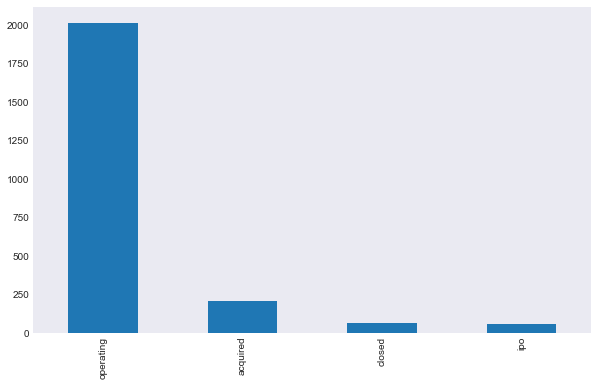

In [4]:
#frequencies of status variables
data['status'].value_counts().plot(kind = 'bar')

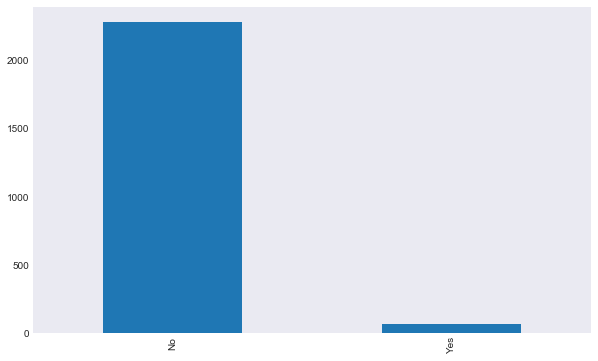

In [5]:
#frequncies of closed varible
data['closed'].value_counts().plot(kind = 'bar')

As you can see the vast majority of the data represents companies that are still operating. I am going to start with the easier two class response closed vs not closed, and then move on to the company status. The issue that we have here, and one that we need to keep in mind for our classification models, is that we have a huge difference in our response variable prior probabilities. The issue may arrive when evaluated performance, here is an example of why this may be an issue. Say we are modeling a rare disease where 99.99 percent of our data does not have the disease and 0.01 percent of our data does have the disease. Then a model that just predicts "no" every time has an error rate of 0.0001, which is very low, but our model obviously sucks.

I am going to start by using a random forest to classify status of a company. The reason I am going to focus on random forests is that random forests allow us to view the variable importance very easily, allowing us to see what predictors are most impactful in company status. Another reason random forests are nice in this case is that the sklearn RandomForestClassifier allows me to weight the response categories by setting class_weight, reducing the issue I discussed before of unbalanced prior probabilities.

I did not realize sklearn's random forest method does not except categorical variables yet. So I'm going to have to convert a bunch of variables into dumby variables. I don't really like this, as an example why, say my 3 levels of a category are 'green', 'red', and 'blue' and an encoder make green = 0, red = 1, blue = 2. Then by this classification red is "in between" green and blue, when this is not the case. However, the alternative is create dumby columns for each category of each variable, and that would create a huge number of predictors, so for now I am going to go with the more naive approach.

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [7]:
#function to transform to encoded numerical variables
def transform_dumby(df, preds_index):
    """
    Description: transform a data predictors into dumby variables
    
    inputs:
        df: pandas data frame
        preds_index: preds_index: eiter an a two item list consisting of the start and stop column index or tuple of predictors column index or a single integer. If it is a single integer we assume this is the first index and predictors are the rest of the df.
    
    out: pandas df with encoded variables
    """
    if not isinstance(preds_index, int):
        start = preds_index[0]
        stop = preds_index[1]
        
        predictor_list = df.columns.values[start:stop]
    else:
        predictor_list = df.columns.values[preds_index:]
        
    for col_name in predictor_list:
        col = df[col_name]
        if not np.issubdtype(col.dtype, np.number):
            label_encoder = preprocessing.LabelEncoder()
            label_encoder.fit(col)
            new_col = label_encoder.transform(col)
            df[col_name] = new_col
    return(df)

In [8]:
#transform the data so random forest can use it
dat = transform_dumby(data, 3)
dat.head()

,closed,status,name,category_code,had_funding,num_investment,num_relationships,num_milestones,logo_height,logo_width,region,degree_type,institution,subject,birthplace,first_name,last_name
7,No,operating,Fundable.com,11,0,3.0,3.0,4.0,120.0,120.0,110,69,701,465,745,344,366
8,No,operating,Wevod,12,1,0.0,2.0,0.0,89.0,250.0,336,317,273,1116,330,797,634
11,No,acquired,Jumptap,22,1,0.0,45.0,3.0,165.0,650.0,57,52,26,352,980,1147,1748
18,Yes,closed,FairSoftware,40,1,0.0,1.0,1.0,67.0,250.0,372,317,894,394,790,29,1508
22,No,operating,WPP,30,0,21.0,23.0,3.0,59.0,86.0,309,199,1182,310,492,507,1731


Now I need to split into test and training sets. One common convention is to use 80 percent of the data as the training set.

In [86]:
#shape of the data
dat.shape

(2348, 17)

In [87]:
import random
#split into test and training set using 80 percent of the data
training = dat.sample(frac = 0.8, random_state = 1)
training.shape

(1878, 17)

In [88]:
#get test data being removing the training rows from data
training_index = list(training.index)

test = dat.drop(training_index, axis = 0)
test.shape

(470, 17)

Now I can seperate the predictors and response variables in the training and test data.

In [93]:
#function to seperate predictors and response in one line
def seperate_preds_response(df, response_var, preds_index):
    """
    decription: function that makes it so I don't have to split into predictors and response for test and traiing data.
    
    inputs:
        df: training or test data frame
        response_var: either a string of the name of the response variable or a list of strings for multiple different response variables
        preds_index: eiter an a two item list consisting of the start and stop column index or tuple of predictors column index or a single integer. If it is a single integer we assume this is the first index and predictors are the rest of the df.
    output:
        List of predictors and response. 
        First item of the list is the data frame of predictors. The rest are the response series.
    """
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError("df must be Pandas DFs")
        
    dfs = []
    
    if not isinstance(preds_index, int):
        start = preds_index[0]
        stop = preds_index[1]
        
        predictor_list = df.columns.values[start:stop]
    else:
        predictor_list = df.columns.values[preds_index:]
        
    predictors = df[predictor_list] 
    
    dfs.append(predictors)
    
    for var in response_var:
        if not isinstance(var, str):
            raise TypeError("columns of response_var must be strings in the data frame")
            
        resp = df[var]
        dfs.append(resp)
        
    return(dfs)

In [94]:
#seperate predictors and response
train_preds, train_closed, train_status = seperate_preds_response(training, ['closed', 'status'], 3)

test_preds, test_closed, test_status = seperate_preds_response(test, ['closed', 'status'], 3)

In [95]:
#training shape
train_preds.shape

(1878, 14)

In [17]:
#test shape
test_preds.shape

(470, 14)

I am now going to fit a random forest classifier on the status of the data.

In [96]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

In [97]:
from sklearn.model_selection import GridSearchCV

Before I fit the random forest model I am going to use GridSearchCV to perform cross validation in order to tune the hyperparameters of the random forest. In the case of this random forest I am going to tune the number of trees in the random forest 'n_estimators' and the parameter 'max_features'. The 'max_features' parameter is the most important parameter for random forests, and determines the maximum number of predictors to random forest will look at when decided how to best split the data. The reason random forests do not look at all of the predictors in the data when creating splits lies in the bias-variance trade off: the random forest will risk increasing bias while reducing variance in limiting the maximum number of features. This reduces any error causes my highly correlated predictors.

Cross Validation allows us to tune these hyperparameters. When looking at the predictive power of a learning model, the accuracy of the model in predicting the data used to train it is a dis-honest evaluation of the model. Cross Validation splits the data in k folds, then for each value of the hyperparameters we are looking at it training the model on all but one of the folds at a time, tests the model on each left out fold. The average perforamnce of each of the k folds is used as the estimated performance of the hyperparameters. Using GridSearchCV I can find the best combination of my two hyperparameters. 

In [99]:
#list of number of predictors examined in the CV
num_preds = np.arange(2, np.ceil(train_preds.shape[1] / 2)).astype(int)

#list of the number of trees used in the CV
n_ests = [50, 100, 150, 200, 250]

In [234]:
#dictionary of parameters to be tuned
params = {'max_features':  num_preds, 'n_estimators': n_ests}

#intialize a random forest classifier.
#random state sets the random set of the classifier
#class_weight = 'balanced_subsample'
rcf = RandomForestClassifier(random_state = 100, oob_score = True,
                            class_weight = 'balanced')

#do 5-fold cross validation the hyperparameters
cv_rcf = GridSearchCV(rcf, params, cv = 5, scoring = 'accuracy',
                      return_train_score = False)

#fit the training data
cv_rcf.fit(train_preds, train_status)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=100, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [235]:
#look at results of the cross validation
cv_results = pd.DataFrame(cv_rcf.cv_results_)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.162062,0.008675,0.857295,2,50,"{'max_features': 2, 'n_estimators': 50}",3,0.854111,0.859043,0.856383,0.856,0.860963,0.018887,0.001419,0.002414
1,0.332536,0.016072,0.857827,2,100,"{'max_features': 2, 'n_estimators': 100}",2,0.854111,0.859043,0.859043,0.856,0.860963,0.050794,0.002413,0.002447
2,0.449464,0.021199,0.857295,2,150,"{'max_features': 2, 'n_estimators': 150}",3,0.854111,0.859043,0.856383,0.856,0.860963,0.017749,0.002143,0.002414
3,0.615088,0.030940,0.857295,2,200,"{'max_features': 2, 'n_estimators': 200}",3,0.854111,0.859043,0.856383,0.856,0.860963,0.026830,0.003676,0.002414
4,0.792293,0.040753,0.857295,2,250,"{'max_features': 2, 'n_estimators': 250}",3,0.854111,0.859043,0.856383,0.856,0.860963,0.027019,0.005228,0.002414


In [236]:
#data frame of variables to examine
scores = cv_results[['mean_test_score', 'param_max_features', 'param_n_estimators']]
scores

,mean_test_score,param_max_features,param_n_estimators
0,0.857295,2,50
1,0.857827,2,100
2,0.857295,2,150
3,0.857295,2,200
4,0.857295,2,250
5,0.857295,3,50
6,0.857295,3,100
7,0.857295,3,150
8,0.857295,3,200
9,0.857295,3,250


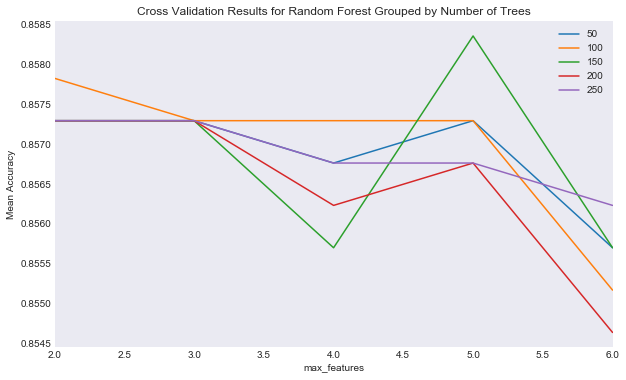

In [237]:
#plot the results of the cross validation grouping by number of trees
ax = plt.subplot()
scores.groupby('param_n_estimators').plot(y = 'mean_test_score', x = 'param_max_features',
                                              kind = 'line', ax = ax)
ax.set_title("Cross Validation Results for Random Forest Grouped by Number of Trees")
ax.set_ylabel("Mean Accuracy")
ax.set_xlabel("max_features")
legend = plt.legend()
_ = [plt.setp(item, 'text', T) for item, T in zip(legend.texts, n_ests)]

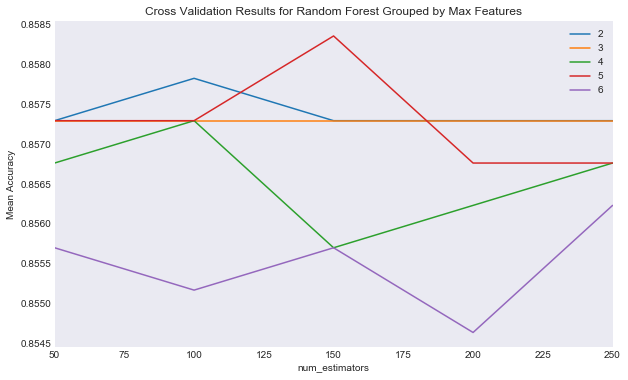

In [238]:
#plot the results of the cross validation grouping by max_features
ax = plt.subplot()
scores.groupby('param_max_features').plot(y = 'mean_test_score', x = 'param_n_estimators',
                                              kind = 'line', ax = ax)
ax.set_title("Cross Validation Results for Random Forest Grouped by Max Features")
ax.set_ylabel("Mean Accuracy")
ax.set_xlabel("num_estimators")
legend = plt.legend()
_ = [plt.setp(item, 'text', T) for item, T in zip(legend.texts, num_preds)]

I can now fit a random forest using the best combination of hyperparameters.

In [239]:
#fit the best cross validation random forest
best_rcf = cv_rcf.best_estimator_
best_rcf.fit(train_preds, train_status)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=100, verbose=0, warm_start=False)

Now I can look at the feature importance of each variable. This is the variable that best splits the data into the status categories.

In [227]:
#create data frame of variable importance
d = {'variable': train_preds.columns.values, 'gini': best_rcf.feature_importances_}
feature_imp = pd.DataFrame(d)
feature_imp

,gini,variable
0,0.060806,category_code
1,0.046401,had_funding
2,0.034524,num_investment
3,0.180875,num_relationships
4,0.067236,num_milestones
5,0.075838,logo_height
6,0.083922,logo_width
7,0.055345,region
8,0.044622,degree_type
9,0.075953,institution


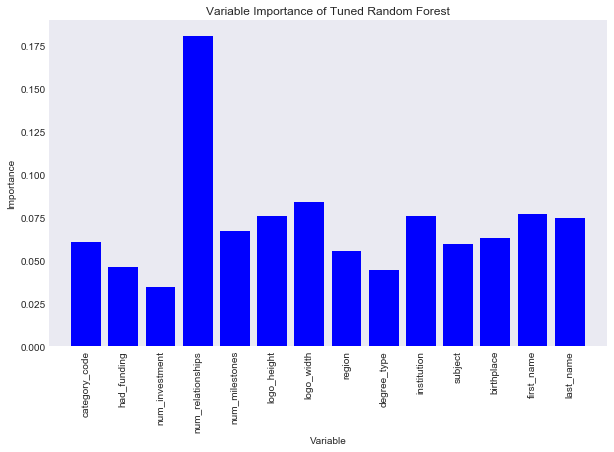

In [228]:
#plot variable importance
imps = best_rcf.feature_importances_
x = range(train_preds.shape[1])
feature_names = train_preds.columns

f, ax = plt.subplots()
plt.bar(x, imps, color = 'b', align = 'center')
plt.xticks(x, feature_names, rotation='vertical')
plt.xlim(-1, train_preds.shape[1])
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance of Tuned Random Forest")
plt.show()

It seems num_relationships best splits our data into the status categories.

One issue I have with the "best" parameters used is how unsually sporatic the perforamce of best number of trees with other values of number of features and vice versa. You can see is the output that the combination of 5 max_features and 150 n_estimatros gave us the best results. Instead it might be nice to look at other combinations of the hyperparameters. For example using 100 for n_estimators and 2 for num_features gave the second best average performance, and both were more stable with other combinations of hyperparamets.

In [187]:
#look at variable importance and test results of second best hyper paramters
feat = 2
trees = 100

#intialize
rcf2 = RandomForestClassifier(n_estimators = 10000, max_features = 5,
                             random_state = 100, oob_score = True,
                             class_weight = 'balanced')
#fit on data
rcf2.fit(train_preds, train_status)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=True, random_state=100, verbose=0, warm_start=False)

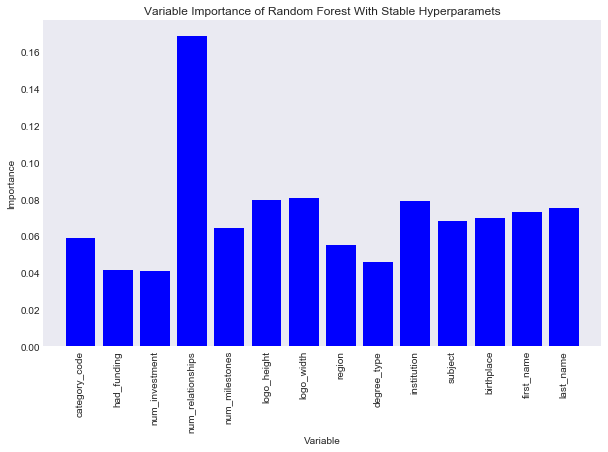

In [188]:
#create data frame of variable importance with new hyperparamers
d2 = {'variable': train_preds.columns.values, 'gini': rcf2.feature_importances_}
feature_imp2 = pd.DataFrame(d2)

#plot variable importance with new hyperparameters
imps2 = rcf2.feature_importances_
x = range(train_preds.shape[1])
feature_names = train_preds.columns

f, ax = plt.subplots()
plt.bar(x, imps2, color = 'b', align = 'center')
plt.xticks(x, feature_names, rotation='vertical')
plt.xlim(-1, train_preds.shape[1])
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance of Random Forest With Stable Hyperparamets")
plt.show()

We have pretty similar results in feature importance as our best hyperparameter combination, so there is reason to believe num_relationships is the predictors that best seperates our data into status categories.

Now I am going to move on to testing. Recall before I mentioned how the issue of class imbalance may effect our learning model. While we were able to find out number of relationships split the data well the status category, we still don't know how well that model predicts unseen data? First let's look at the accuracy of our model.

In [290]:
#look at accuracy of the data
test_status_score = best_rcf.score(test_preds, test_status)
test_status_score

0.86170212765957444

Not bad. However, I mentioned before the issue with just looking at accuracy in classification cases like this one. Below I will show the confusion matrix of the predictions our model made. In a confusion matrix, the number in the ith row and jth column is the number of individuals we predicted to be in the "ith" class, but is really in the "jth" class, based on some ordering. I provide the ordering in a list before the confusion matrix is printed.

In [291]:
from sklearn.metrics import confusion_matrix
#class predictions
preds_status_forest = best_rcf.predict(test_preds)
#confusion matrix
labs = list(set(test_status))
print(labs)
cf = confusion_matrix(test_status, preds_status_forest, labels = labs)
print(cf)

['operating', 'closed', 'acquired', 'ipo']
[[404   0   0   3]
 [ 14   0   0   0]
 [ 35   0   0   0]
 [ 13   0   0   1]]


As you can see, the model did not do very well. Only 4 cases in the test sample were predicted to be not 'operating', showing the model really did not do well. I thought that possibilty changing the scoring attribute of GridSearchCV to something based on an f1 score or precion could help, however, the results of the final confusion matrix in generally remained the same no matter the hyperparameters. Based on what I found online, it turns out sklearn is still not so great with really inbalanced data sets like the one I am working with. In theory, I could have used an f1 score, however, that still wasn't working once a fit the data. I saw some pretty heated people talking on stack overflow about this issue, and it seemed even the class_weight attribute could not help me here. Basically, because sklearn's fit method optimized by accuracy. I was unable to find a solution to this. Instead I am going to use the probabilities an individual is of an unrepresented class and manually predict that class if the probability is over a tuned lower threshold.

To make matters easier I am going to move on to the two category 'closed' response variable. After fitting the model, instead of using the predict method I am going to define my own prediction based on prediction probabilites. Random Forest classify a row to the class it has the highest probability of being a part of, but instead I can predict a row to be closed based on a tuned decion boundary.

# Closed

First, I tried to pick hyper parameters for my random forest for the closed response variable, however, I was getting consistantly the same error rate no matter what parameter I used. That was because one again, and this was the case even after I tried chaning hyperparameters to be tuned or changed the scoring metric, I was constantly getting models that only predicted no. Instead, what I am going to do is just use the hyperparameters from before, and then work from there. This is not good practise, however, the closed variable is just a dumby indicator for the closed column from my previous model.

In [295]:
#make closed model
params = {'max_features':  num_preds, 'n_estimators': n_ests}

rcf_closed = RandomForestClassifier(random_state = 100, oob_score = True,
                             class_weight = 'balanced')

cv_rcf_closed = GridSearchCV(rcf, params, cv = 5, scoring = 'accuracy',
                      return_train_score = False)

#cv_rcf.fit(train_preds, train_closed)
cv_rcf_closed.fit(train_preds, train_closed)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=100, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([2, 3, 4, 5, 6]), 'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

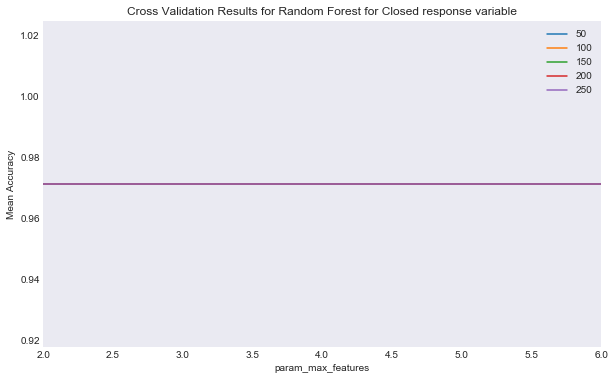

In [296]:
#plot cross validation results, show that there is a serious issue
scores_closed = pd.DataFrame(cv_rcf_closed.cv_results_)
cv_results_closed = scores_closed[['mean_test_score', 'param_max_features', 'param_n_estimators']]
ax = plt.subplot()
cv_results_closed.groupby('param_n_estimators').plot(y = 'mean_test_score', x = 'param_max_features',
                                              kind = 'line', ax = ax)
ax.set_title("Cross Validation Results for Random Forest for Closed response variable")
ax.set_ylabel("Mean Accuracy")
legend = plt.legend()
_ = [plt.setp(item, 'text', T) for item, T in zip(legend.texts, n_ests)]

In [297]:
#make closed using hyperparameters from before
rcf_closed = RandomForestClassifier(random_state = 100, oob_score = True,
                                    class_weight = 'balanced', max_features = 5,
                                   n_estimators = 150)
rcf_closed.fit(train_preds, train_closed)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=100, verbose=0, warm_start=False)

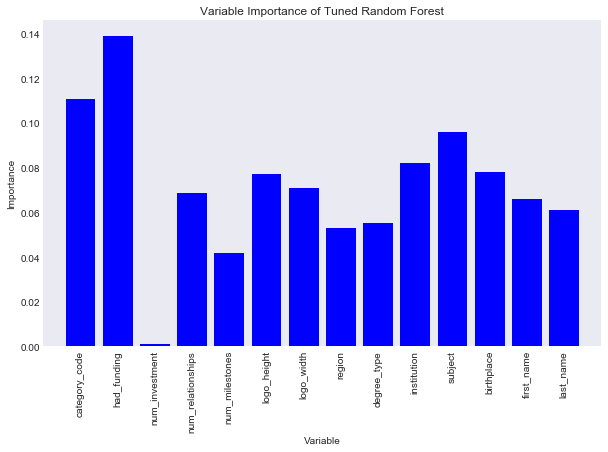

In [298]:
#look at variable importance
d = {'variable': train_preds.columns.values, 'gini': rcf_closed.feature_importances_}
feature_imp_closed = pd.DataFrame(d)
imps_closed = rcf_closed.feature_importances_
x = range(train_preds.shape[1])
feature_names = train_preds.columns

f, ax = plt.subplots()
plt.bar(x, imps_closed, color = 'b', align = 'center')
plt.xticks(x, feature_names, rotation='vertical')
plt.xlim(-1, train_preds.shape[1])
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance of Tuned Random Forest")
plt.show()

One interesting thing is that num_relationships is no longer the most important feature here, instead it is had_funding. That does make sense, in that companies that recieved funding are more likely to stay in business than companies that do not. Category code now comes in second, and school subject and institution have moved up in relative importance.

In [299]:
#look at test score
rcf_closed.score(test_preds, test_closed)

0.97021276595744677

In [300]:
#look at test confusion matrix
preds_closed_forest = rcf_closed.predict(test_preds)
#confusion matrix
labs = list(set(test_closed))
print(labs)
cf_closed = confusion_matrix(test_closed, preds_closed_forest, labels = labs)
print(cf_closed)

['No', 'Yes']
[[456   0]
 [ 14   0]]


I am going to start by showing how one can lower the tolerance and self make predictions using the test data. I am going to start by saying, if the probability that the individual is closed is greater than the the frequency of closed individuals in the training set, then classify as closed.

In [305]:
#classify based on very low tolerance
new = (clf.predict_proba(test_preds)[:,1] > (list(train_closed.values).count('Yes')/train_closed.size))

In [306]:
#Change to form of response variable
new_preds = ['Yes' if n else 'No' for n in new]

In [307]:
#create confusion matrix
labs = list(set(test_closed))
print(labs)
cf_closed_new = confusion_matrix(test_closed, new_preds, labels = labs)
print(cf_closed_new)

['No', 'Yes']
[[319 137]
 [  3  11]]


Interestingly, that actually did pretty well. While there is a much greater number of false positive now, the was this data set turned out kind of like data for a predicting if a persion has a rare disease. For those types of classification problems, generally you are ok with a large number of false positve, as opposed to any false negatives.

## Using dumby

In [97]:
long = pd.read_hdf('results/classification_data.h5', 'classification_data')
long.head()

,closed,status,name,category_code,had_funding,num_investment,num_relationships,num_milestones,logo_height,logo_width,region,degree_type,institution,subject,birthplace,first_name,last_name
7,No,operating,Fundable.com,finance,No,3.0,3.0,4.0,120.0,120.0,Columbus,BBA,Ohio State University,"Entrepreneurship, Marketing",Ohio,Eric,Corl
8,No,operating,Wevod,games_video,Yes,0.0,2.0,0.0,89.0,250.0,Paris,MS,EPITECH,computer sciences and technologies,France,Nassim,Ghandour
11,No,acquired,Jumptap,mobile,Yes,0.0,45.0,3.0,165.0,650.0,Boston,BA,American University,Economics,"St. Petersburg, Russia",Veronika,Sonsev
18,Yes,closed,FairSoftware,web,Yes,0.0,1.0,1.0,67.0,250.0,SF Bay,MS,Supelec,Electrical Engineering,"Paris, France",Alain,Raynaud
22,No,operating,WPP,public_relations,No,21.0,23.0,3.0,59.0,86.0,New York,Degree,University of Kentucky,Degree,Kentucky,Jack,Smith


In [99]:
l = pd.get_dummies(long)
l.head()

,num_investment,num_relationships,num_milestones,logo_height,logo_width,closed_No,closed_Yes,status_acquired,status_closed,status_ipo,...,last_name_paunikar,last_name_raj,last_name_rokade,last_name_seo,last_name_sk,last_name_termini,last_name_van Apeldoorn,last_name_van Loo,last_name_van der Chijs,last_name_von Wallenstein
7,3.0,3.0,4.0,120.0,120.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.0,2.0,0.0,89.0,250.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0.0,45.0,3.0,165.0,650.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0.0,1.0,1.0,67.0,250.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22,21.0,23.0,3.0,59.0,86.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
long_preds, long_closed, long_status = seperate_preds_response(long, ['closed', 'status'], 3)
long_preds.head()

,category_code,had_funding,num_investment,num_relationships,num_milestones,logo_height,logo_width,region,degree_type,institution,subject,birthplace,first_name,last_name
7,finance,No,3.0,3.0,4.0,120.0,120.0,Columbus,BBA,Ohio State University,"Entrepreneurship, Marketing",Ohio,Eric,Corl
8,games_video,Yes,0.0,2.0,0.0,89.0,250.0,Paris,MS,EPITECH,computer sciences and technologies,France,Nassim,Ghandour
11,mobile,Yes,0.0,45.0,3.0,165.0,650.0,Boston,BA,American University,Economics,"St. Petersburg, Russia",Veronika,Sonsev
18,web,Yes,0.0,1.0,1.0,67.0,250.0,SF Bay,MS,Supelec,Electrical Engineering,"Paris, France",Alain,Raynaud
22,public_relations,No,21.0,23.0,3.0,59.0,86.0,New York,Degree,University of Kentucky,Degree,Kentucky,Jack,Smith


In [ ]:
long_preds = pd.get_dummies(long_preds)
long_preds.head()

In [ ]:
num_preds = np.arange(2, np.ceil(np.sqrt(long_preds.shape[1])) + 1, step = ).astype(int)

In [ ]:
params = {'max_features':  num_preds, 'n_estimators': n_ests}
rcf_long = RandomForestClassifier(random_state = 100,
                             class_weight = 'balanced')
cv_rcf_long = GridSearchCV(rcf_long, params, cv = 5, scoring = 'accuracy',
                      return_train_score = False)

cv_rcf_long.fit(long_preds, long_status)

In [ ]:
scores = [x[1] for x in cv_rcf_long.grid_scores_]
scores = pd.DataFrame(cv_rcf_long.cv_results_)
scores